In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy.stats import pearsonr, spearmanr
from sklearn import linear_model
from sklearn.metrics import r2_score
from adjustText import adjust_text
from functools import partial
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pd.set_option('chained_assignment',None)
from matplotlib.backends.backend_pdf import PdfPages

In [82]:
def clean_strings(val):
    if isinstance(val, str):
        clean = val.replace('<', '')
        clean = clean.replace('>', '')
        try:
            return(float(clean))
        except ValueError:
            return(np.nan)
    elif isinstance(val, float) or isinstance(val, int):
        return(float(val))
    else:
        return(np.nan)

In [83]:
main_data = pd.read_csv('C:/Users/lzoeckler/Desktop/mali_meta/for_viz.csv')
val_cols = ['HRP2_pg_ml', 'LDH_Pan_pg_ml', 'LDH_Pv_pg_ml', 'CRP_ng_ml']
main_data[val_cols] = main_data[val_cols].applymap(clean_strings)
main_data[val_cols] = main_data[val_cols].applymap(np.log10)
main_data = main_data[['id_number', 'HRP2_pg_ml', 'LDH_Pan_pg_ml',
                       'LDH_Pv_pg_ml', 'CRP_ng_ml', 'timepoint_days', 'date_dif',
                       'drug', 'age_yrs', 'RDT_pos', 'HRP2_result',
                       'LDH_Pan_result', 'LDH_Pv_result']]
main_data.rename(columns={'id_number': 'participant_id'}, inplace=True)
pos_vals = main_data.loc[main_data['RDT_pos'] == 1]
pos_vals.loc[pos_vals['HRP2_pg_ml'] < 1.4, 'RDT_pos'] = -999
neg_vals = main_data.loc[main_data['RDT_pos'] != 1]
main_data = pd.concat([pos_vals, neg_vals])
rdt_vars = {'RDT_pos': {0: 'green', 1: 'red', 2: 'yellow', np.nan: 'black'}}
main_data.replace(rdt_vars, inplace=True)
null_days = main_data.loc[main_data['timepoint_days'].isnull()]
null_days = null_days.loc[~null_days['drug'].isnull()]
null_days['timepoint_days'] = null_days['date_dif']
main_data = main_data.loc[~main_data['timepoint_days'].isnull()]
main_data = pd.concat([null_days, main_data])
main_data.head()

participant_id  HRP2_pg_ml  LDH_Pan_pg_ml  LDH_Pv_pg_ml  CRP_ng_ml  \
70              304         NaN            NaN           NaN        NaN   
89              307         NaN            NaN           NaN        NaN   
148             310         NaN            NaN           NaN        NaN   
279             318         NaN            NaN           NaN        NaN   
281             318         NaN            NaN           NaN        NaN   

     timepoint_days  date_dif                     drug  age_yrs RDT_pos  \
70             98.0      98.0                  COARTEM      NaN   black   
89             67.0      67.0                  COARTEM    41.38   black   
148            30.0      30.0  ARTEMETHER LUMEFANTRINE    26.63   black   
279           -26.0     -26.0                  COARTEM    49.13   black   
281           117.0     117.0                  COARTEM    49.53   black   

    HRP2_result LDH_Pan_result LDH_Pv_result  
70          NaN            NaN           NaN  
89          NaN            NaN           NaN  
148         NaN            NaN           NaN  
279         NaN            NaN           NaN  
281         NaN            NaN           NaN

In [84]:
class_data = main_data.copy(deep=True)
garbage_pids = [316, 317, 371, 396, 416, 441, 461, 500]
idk = [330]
questionable_pids = [311, 335, 352, 398, 473, 491, 496, 497]
usable_data = class_data.loc[~class_data['participant_id'].isin(garbage_pids)]
usable_data = usable_data.loc[~usable_data['participant_id'].isin(idk)]
usable_data['class'] = 'purple'

In [79]:
all_study_days = []
all_other_days = []
for pid in usable_data['participant_id'].unique():
    pid_data = usable_data.loc[usable_data['participant_id'] == pid]
    null_dates = pid_data.loc[pid_data['date_dif'].isnull()]
    if len(null_dates) == len(pid_data):
        pid_data['date_dif'] = pid_data['timepoint_days']
    pid_data.sort_values('date_dif', inplace=True)
    study_days = pid_data.loc[~pid_data['HRP2_pg_ml'].isnull(), 'date_dif']
    treatment_days = pid_data.loc[~pid_data['drug'].isnull(), 'date_dif'].tolist()
    infection = 0
    for day in study_days:
        day_data = pid_data.loc[pid_data['date_dif'] == day]
        try:
            day_hrp2 = day_data['HRP2_pg_ml'].item()
        except ValueError:
            print(pid, day)
            pass
        # classify "uninfected" points
        if infection != 1:
            if day_hrp2 < .5:
                day_data['class'] = 'blue'
            else:
                infection = 1
        # classify other points
        if len(treatment_days) > 0:
            symp = 0
            for tday in treatment_days:
                # classify "symptomatic" points
                # SOMETHING WRONG HERE
                if ((tday - 2) <= day <= (tday + 2)):
                    day_data['class'] = 'red'
                    infection = 1
                    symp = 1
                elif ((day - 2) < tday) and symp == 0:
                    if day_hrp2 > 3:
                        day_data['class'] = 'yellow'
                        infection = 1
                    elif day_hrp2 < 1.4 and infection != 1:
                        day_data['class'] = 'blue'
                elif ((day + 2) > tday) and symp == 0:
                    day_data['class'] = 'green'
                    infection = 1
        else:
            if day_hrp2 > 1.4:
                day_data['class'] = 'yellow'
                infection = 1
        all_study_days.append(day_data)
    all_other_days.append(pid_data.loc[pid_data['HRP2_pg_ml'].isnull()])
all_study_days = pd.concat(all_study_days)
all_other_days = pd.concat(all_other_days)
classed_data = pd.concat([all_study_days, all_other_days])

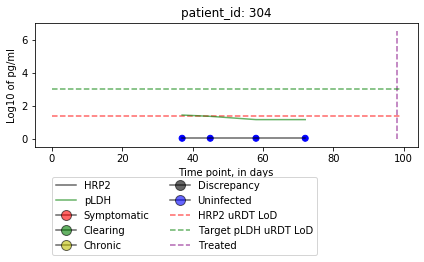

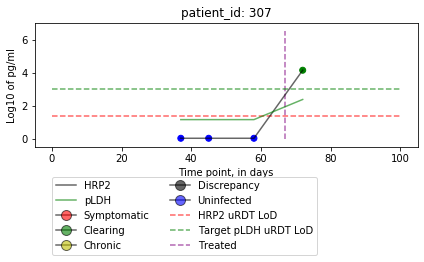

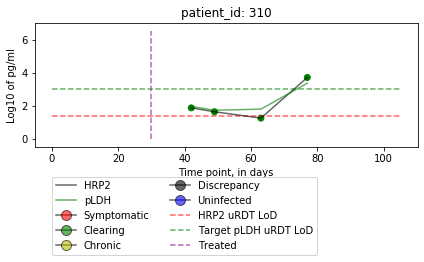

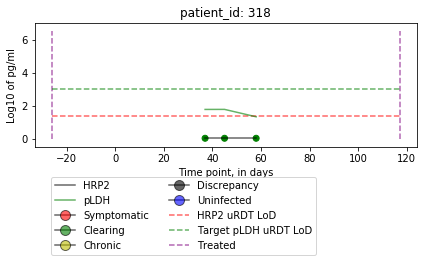

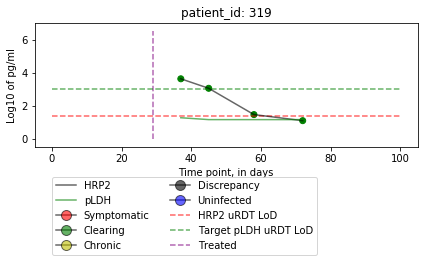

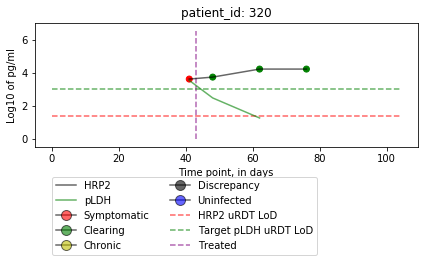

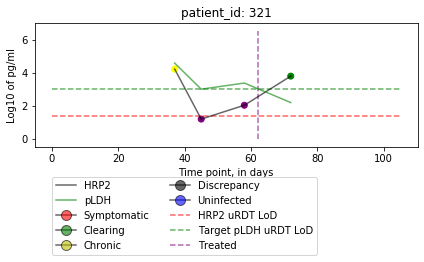

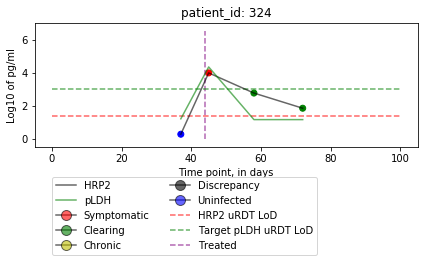

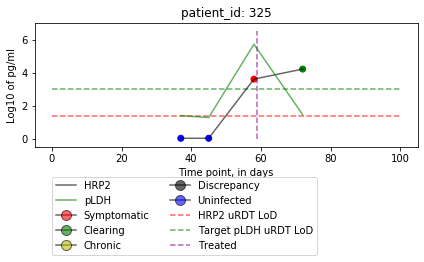

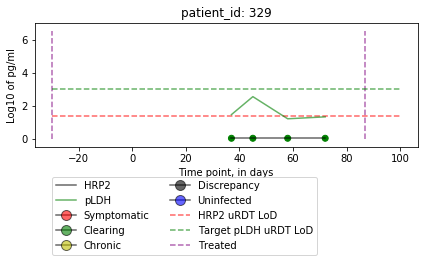

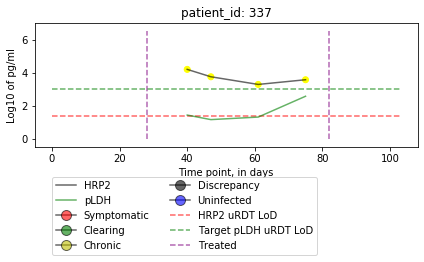

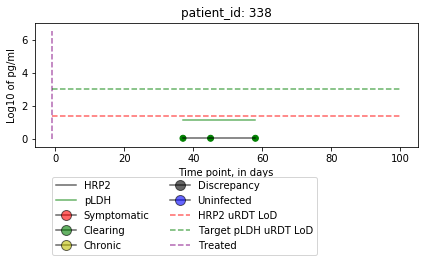

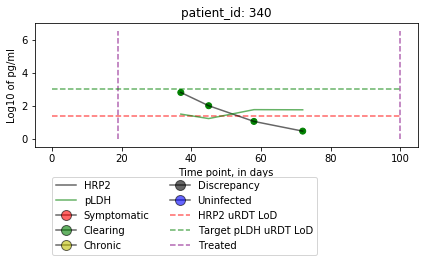

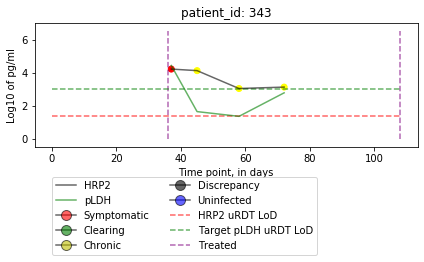

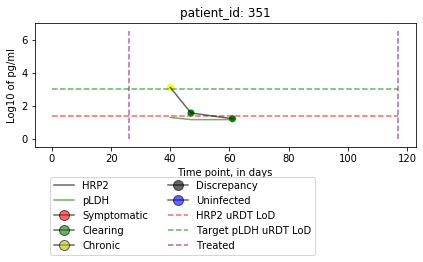

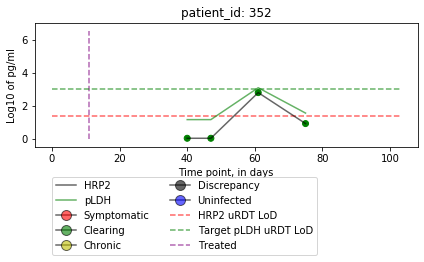

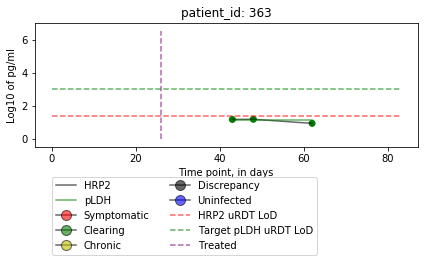

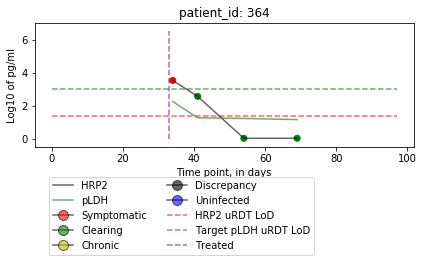

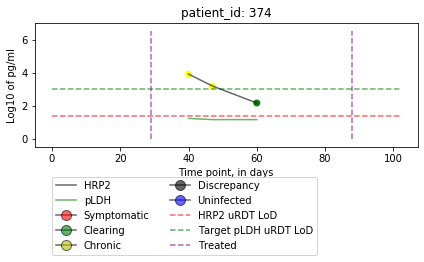

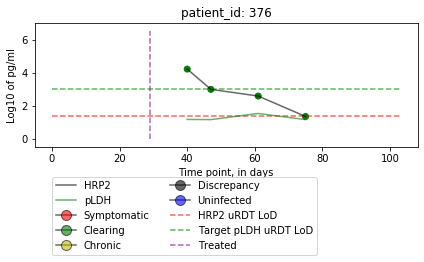

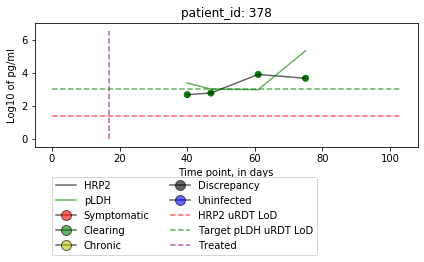

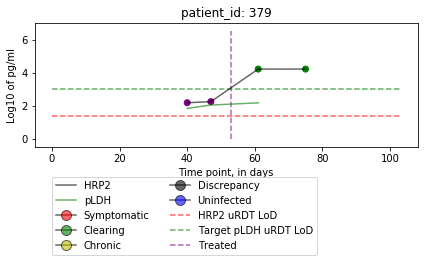

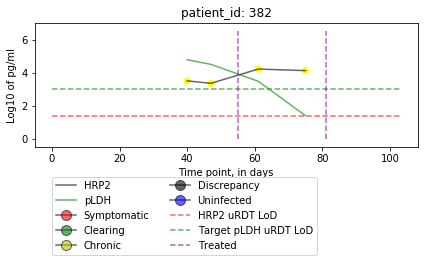

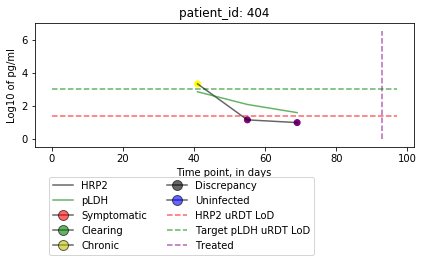

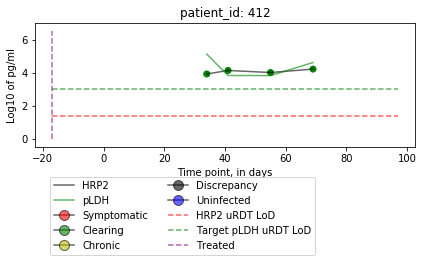

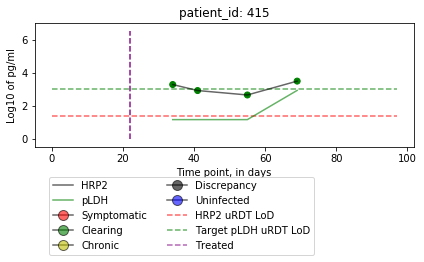

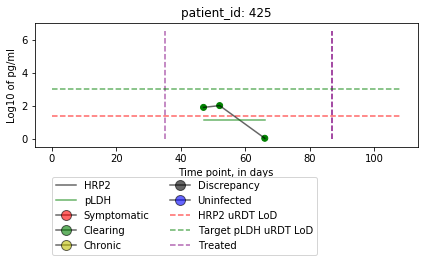

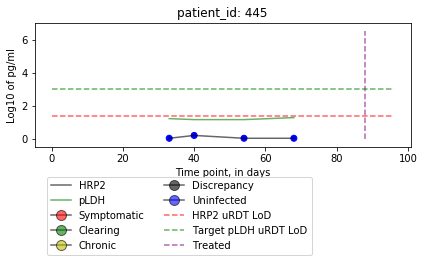

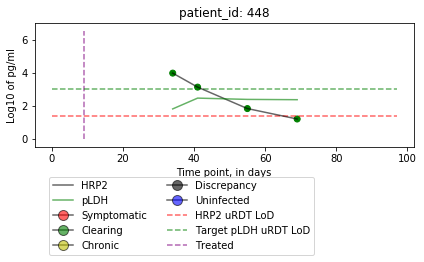

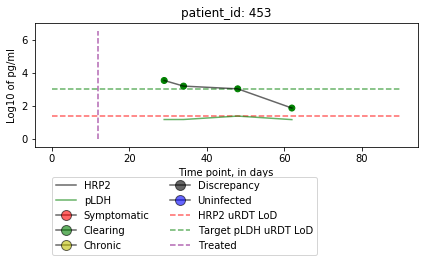

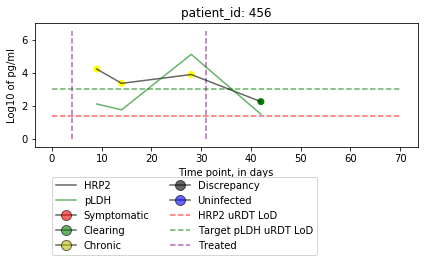

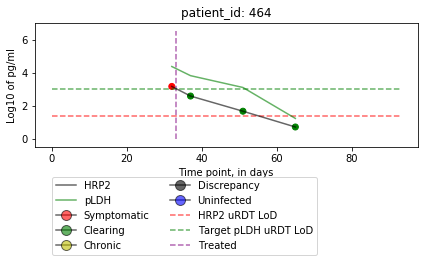

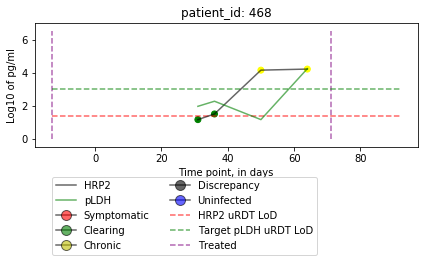

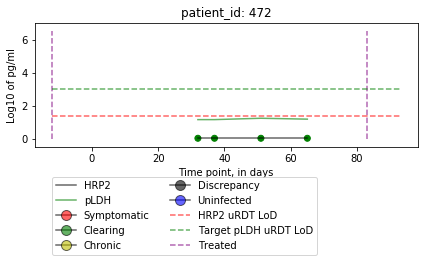

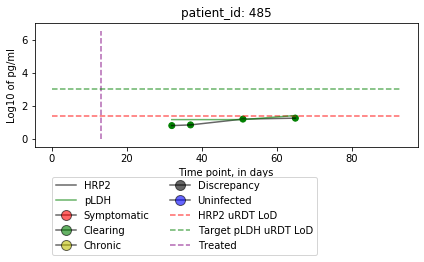

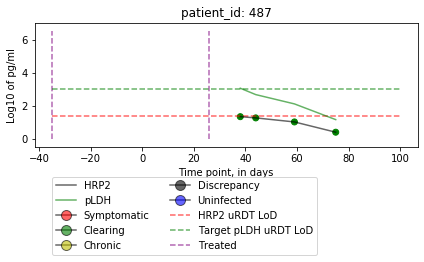

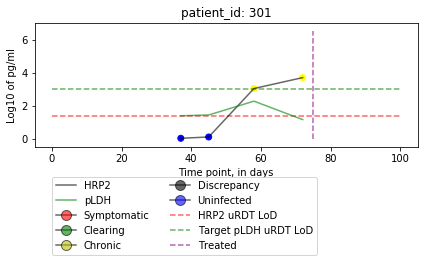

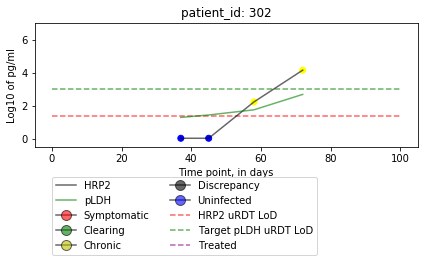

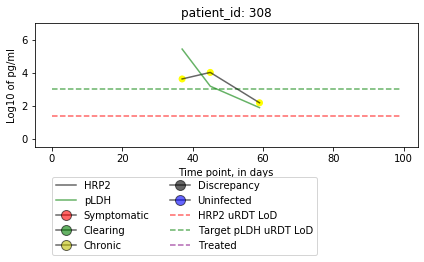

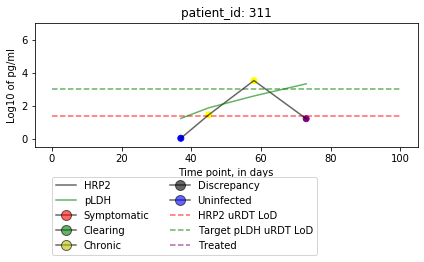

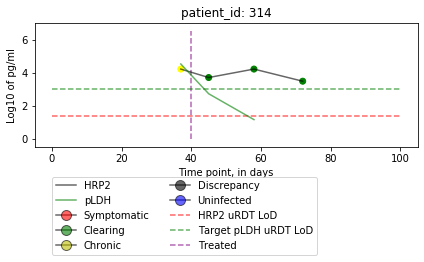

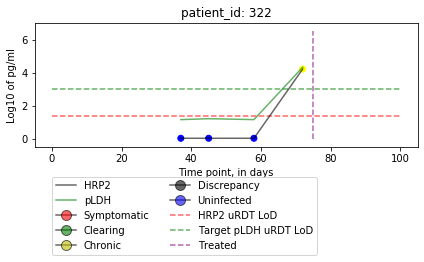

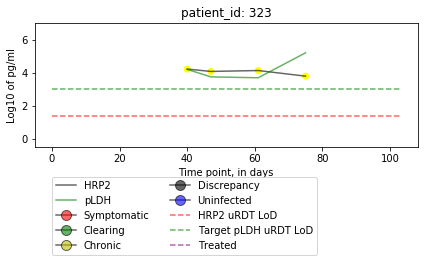

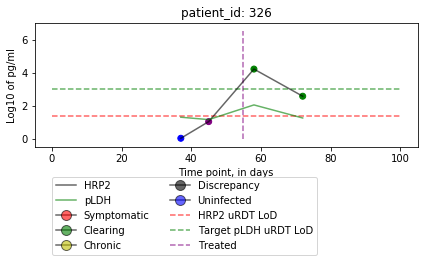

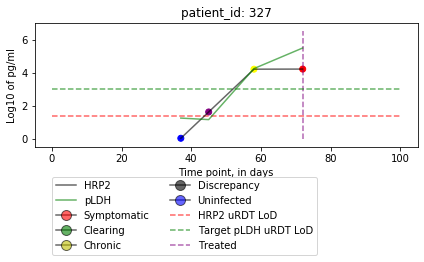

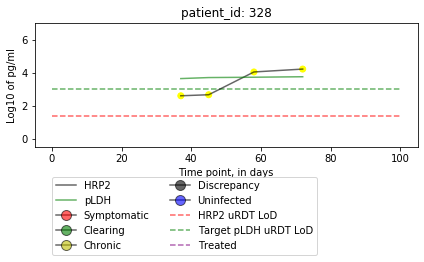

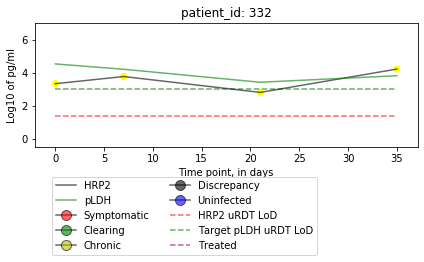

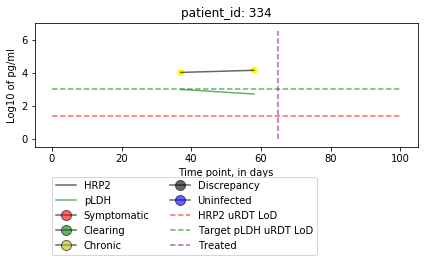

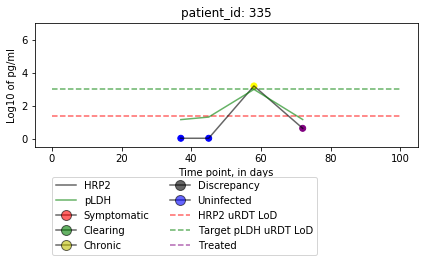

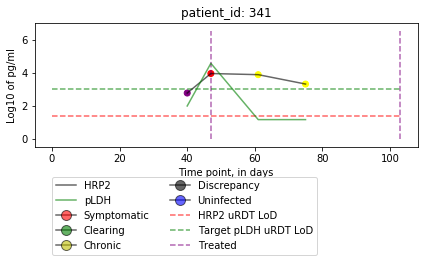

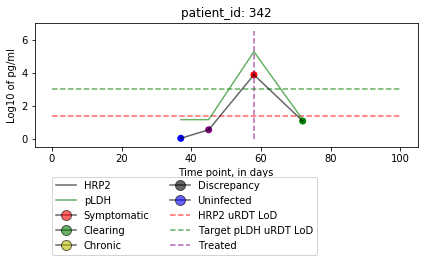

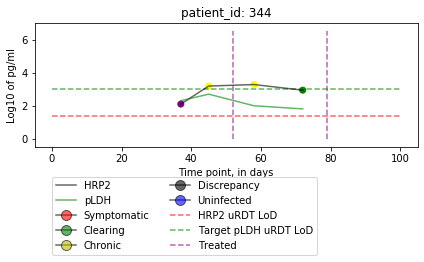

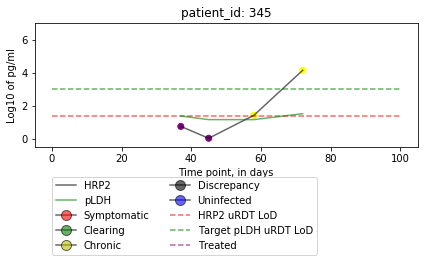

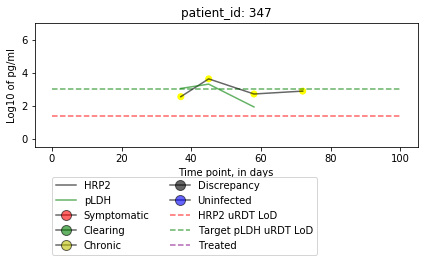

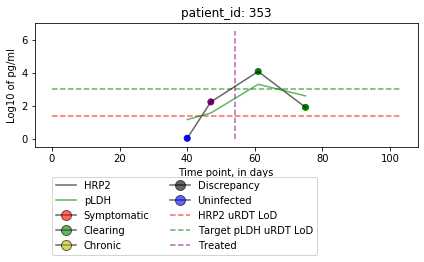

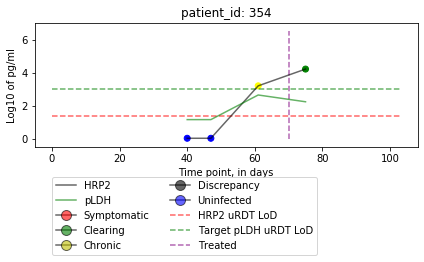

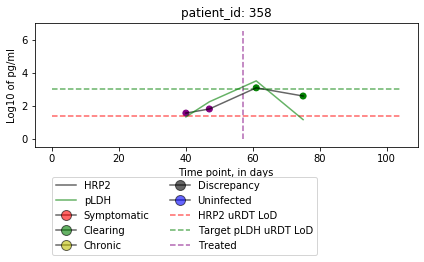

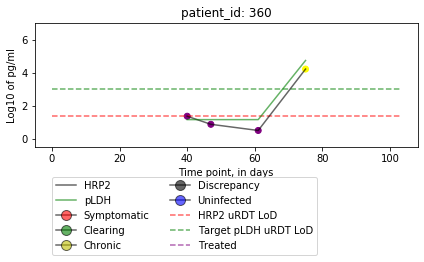

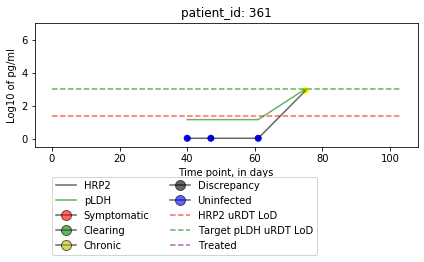

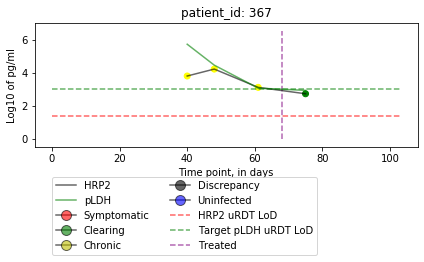

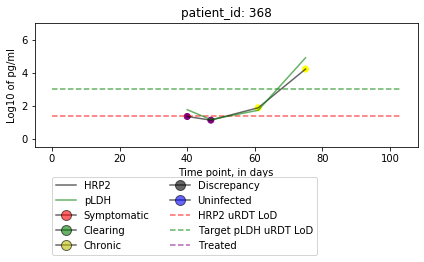

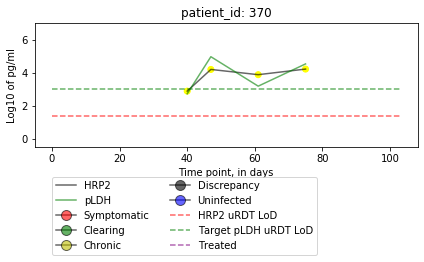

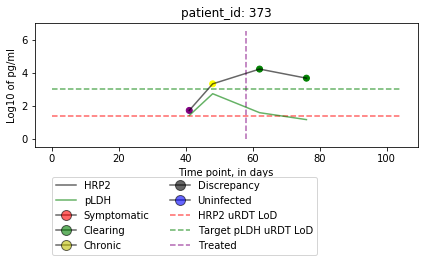

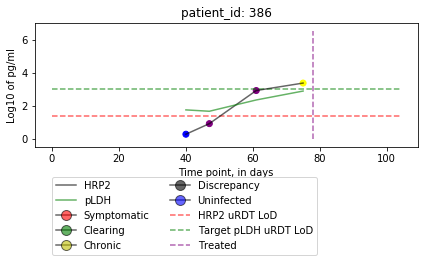

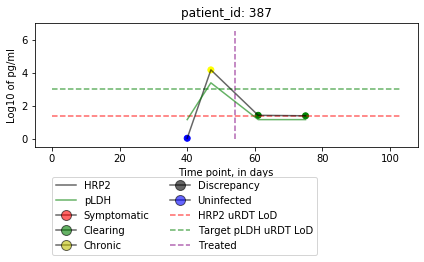

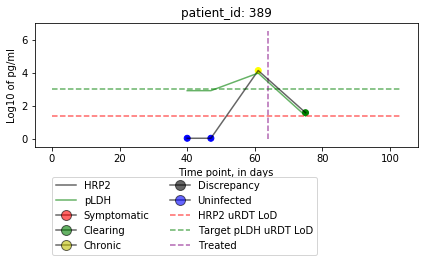

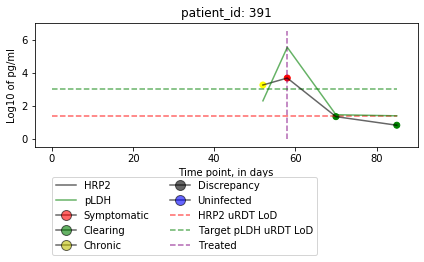

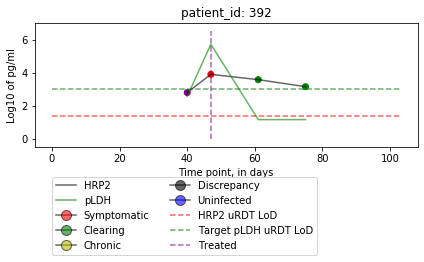

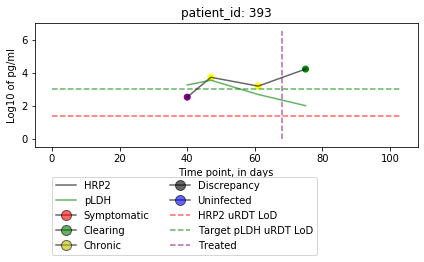

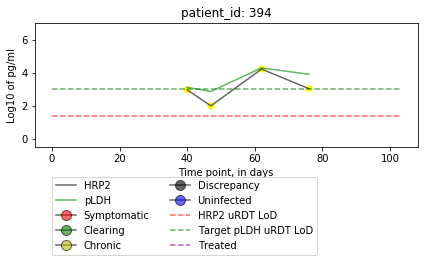

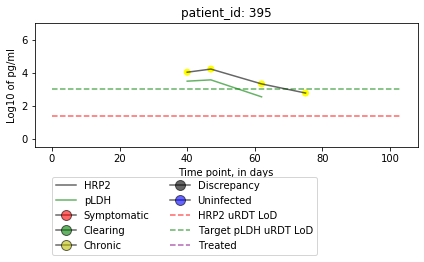

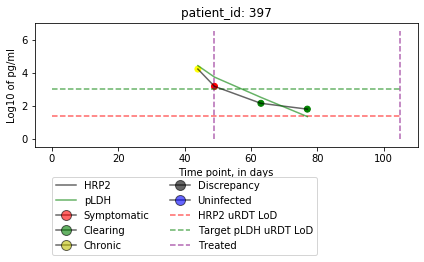

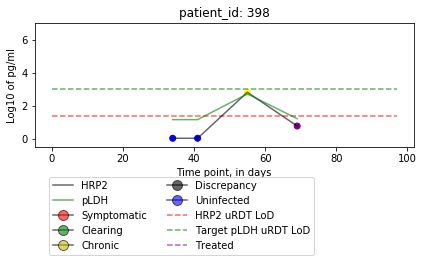

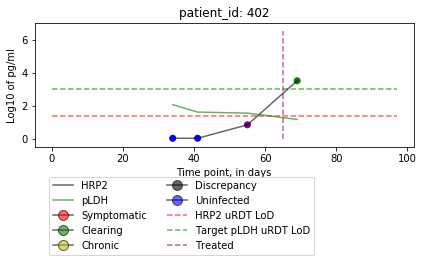

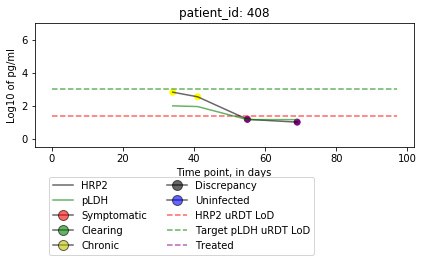

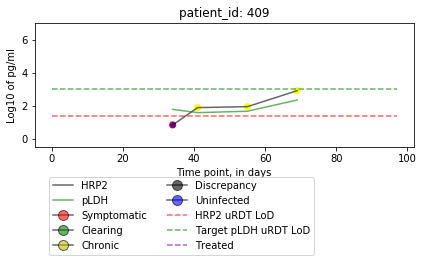

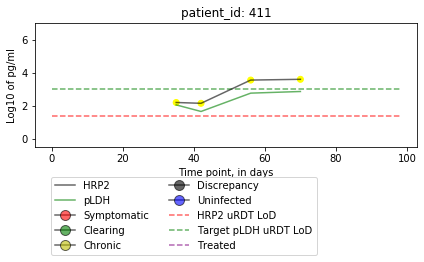

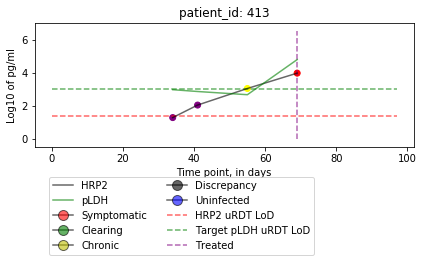

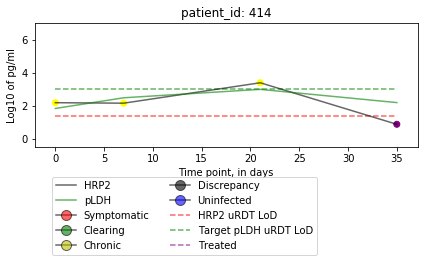

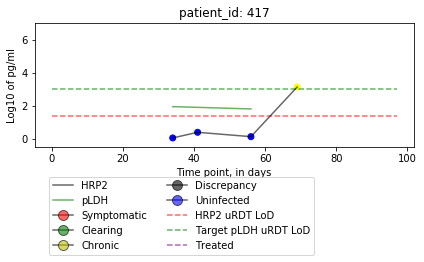

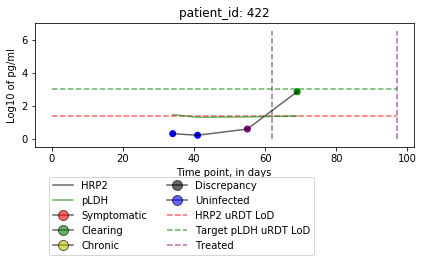

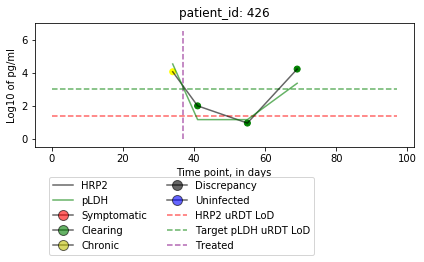

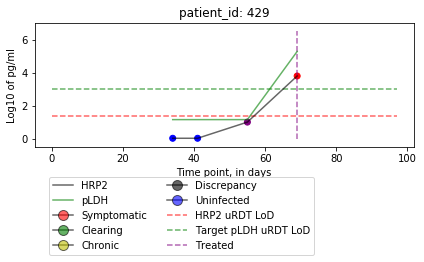

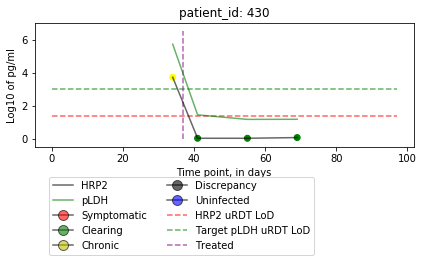

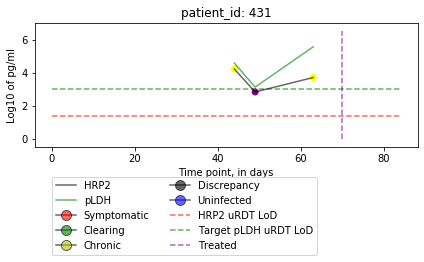

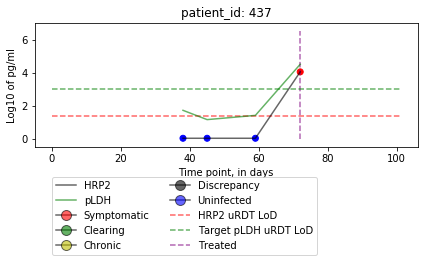

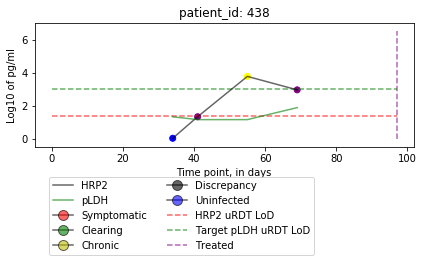

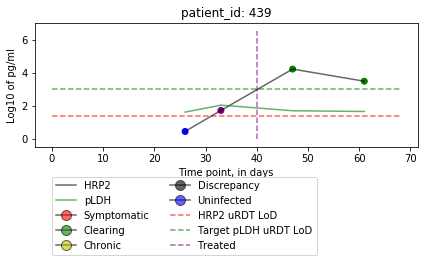

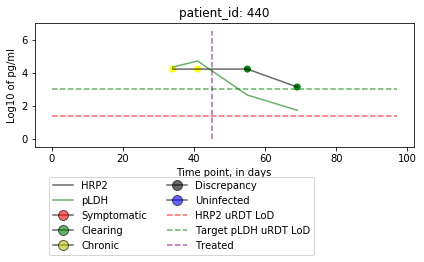

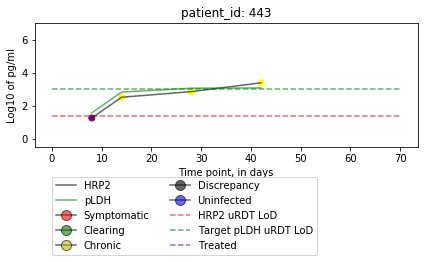

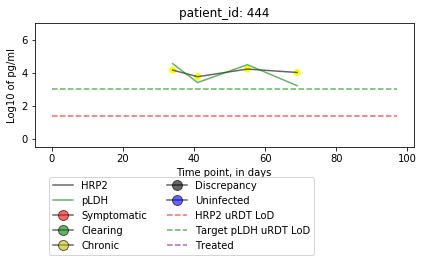

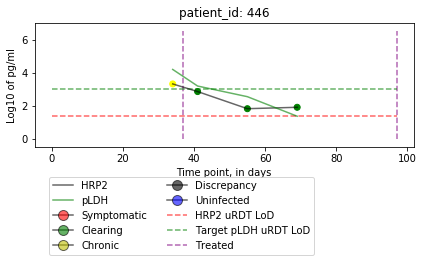

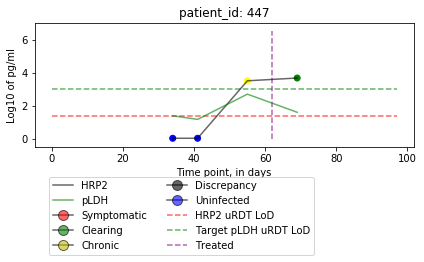

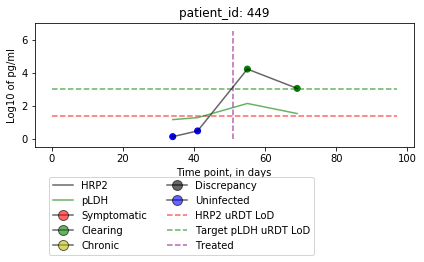

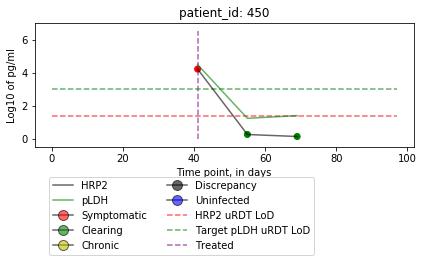

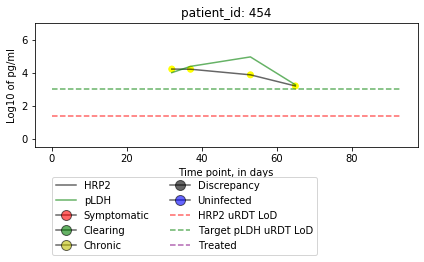

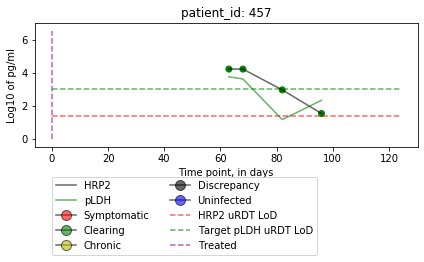

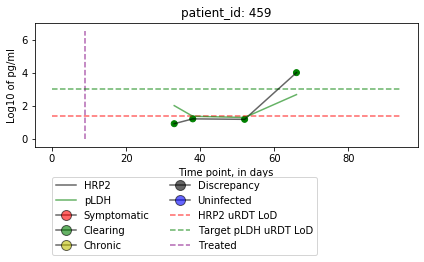

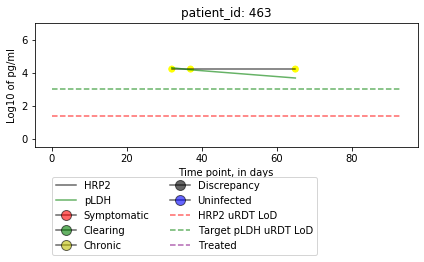

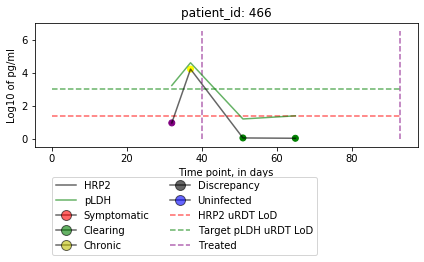

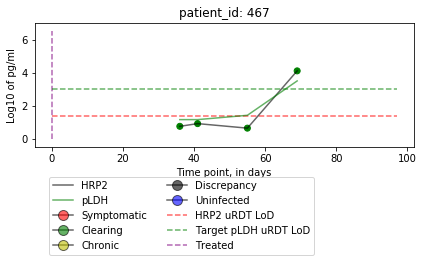

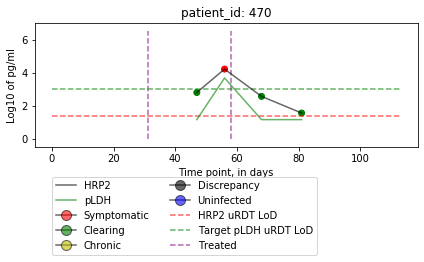

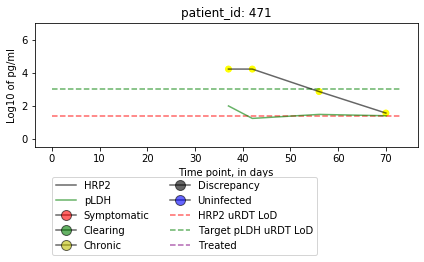

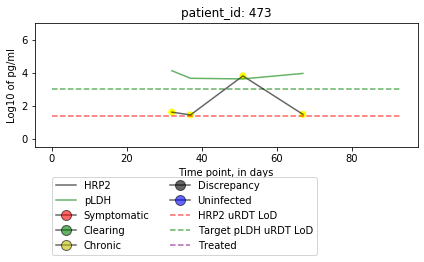

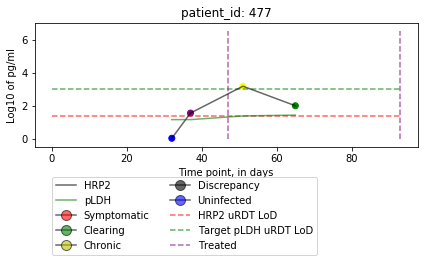

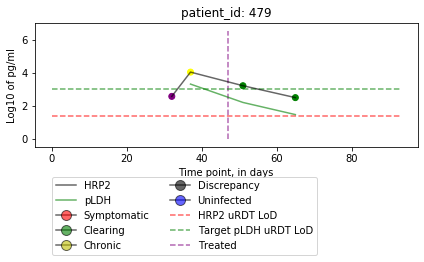

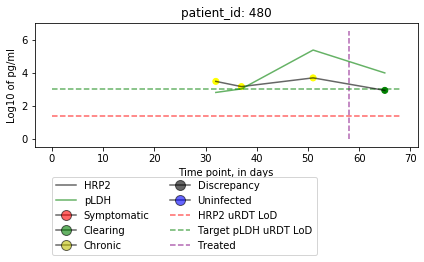

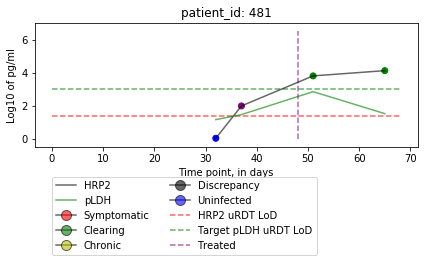

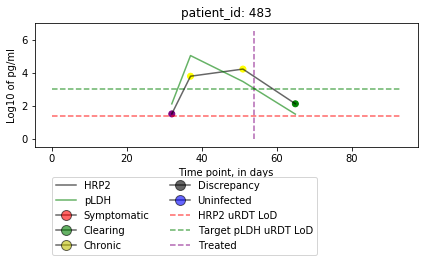

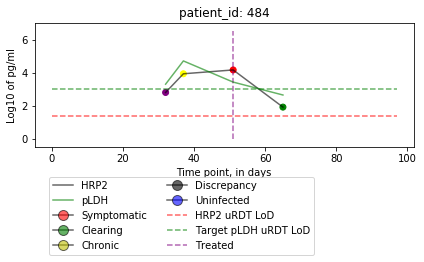

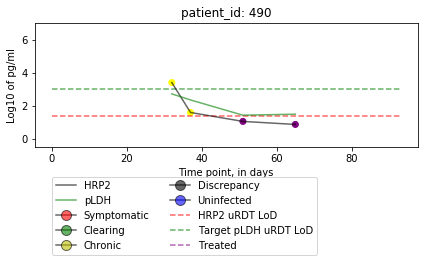

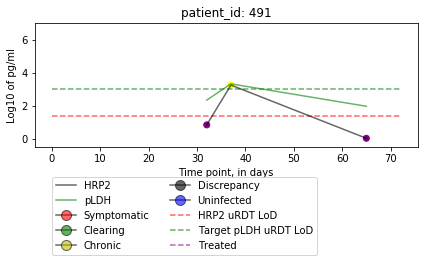

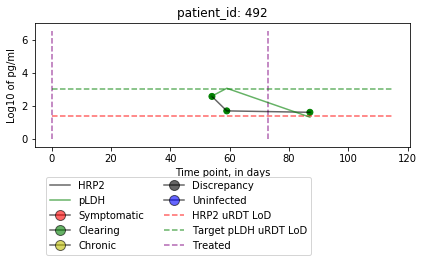

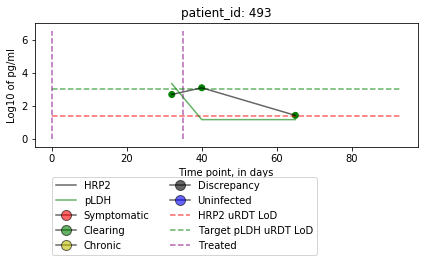

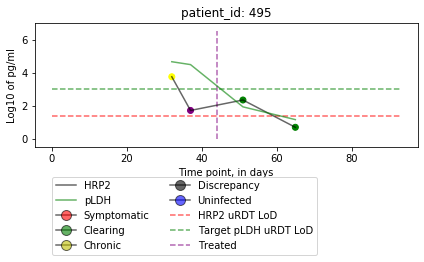

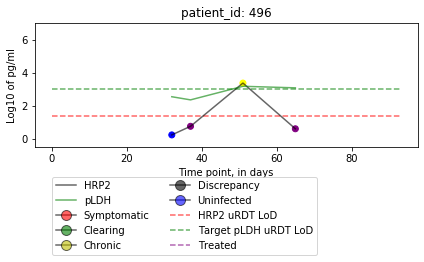

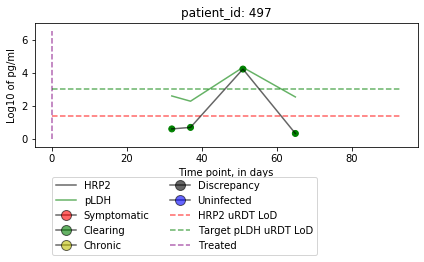

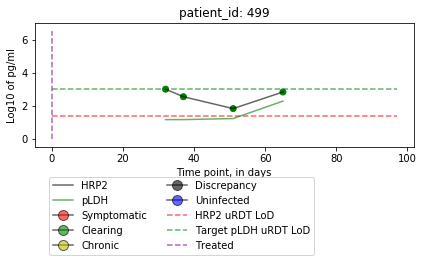

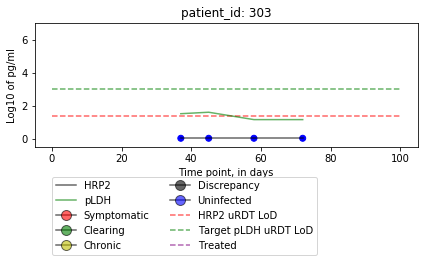

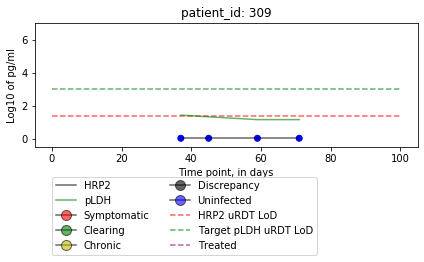

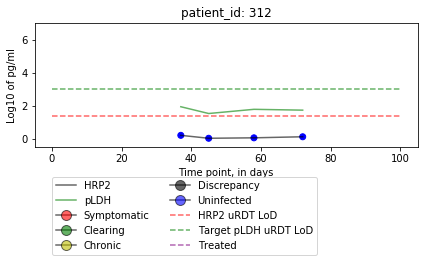

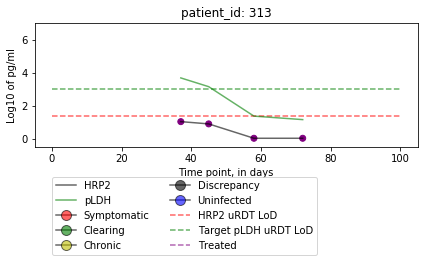

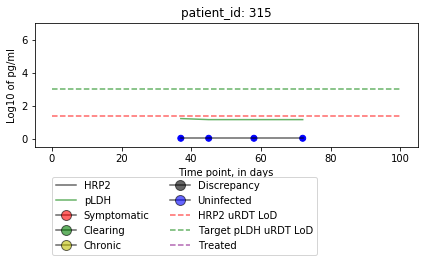

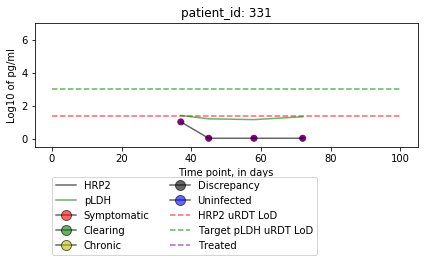

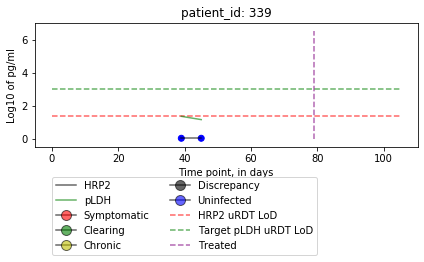

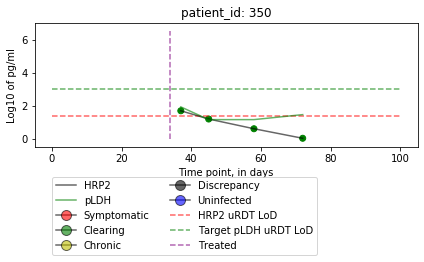

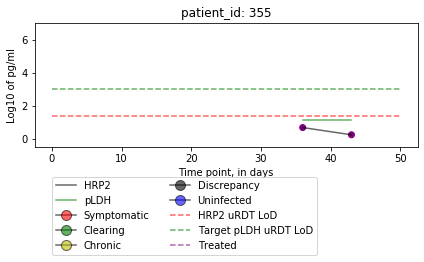

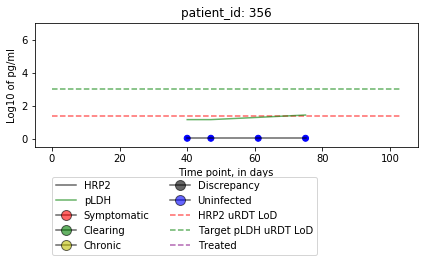

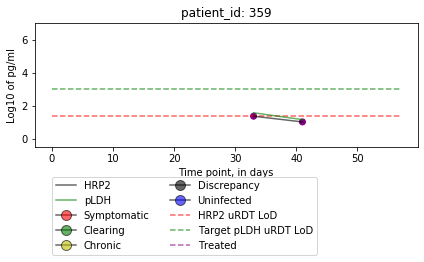

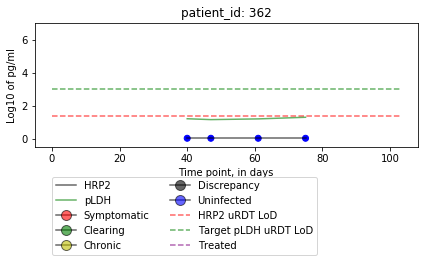

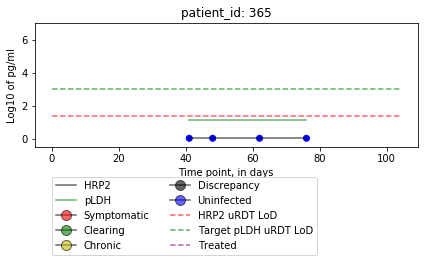

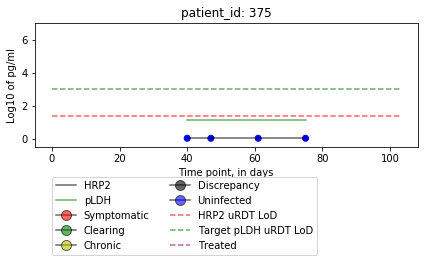

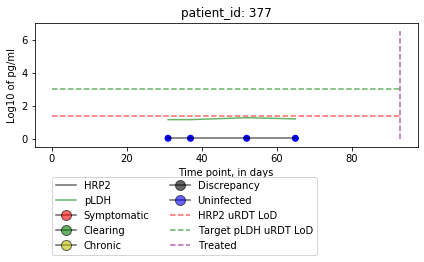

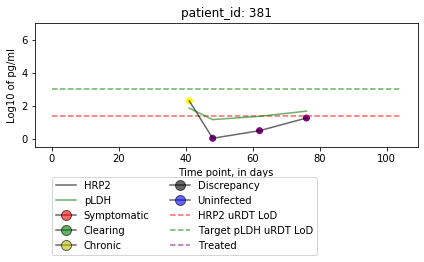

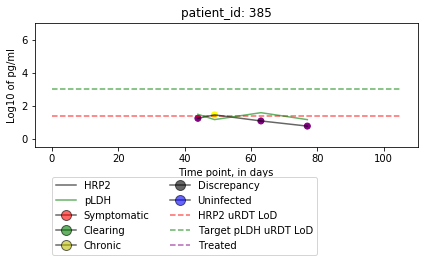

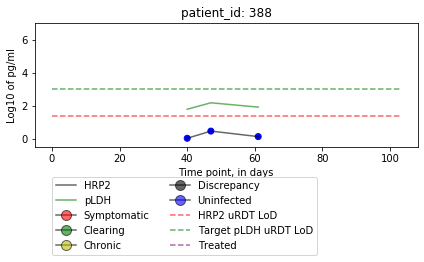

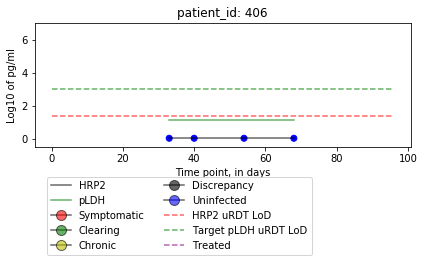

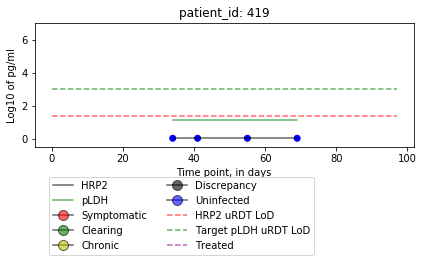

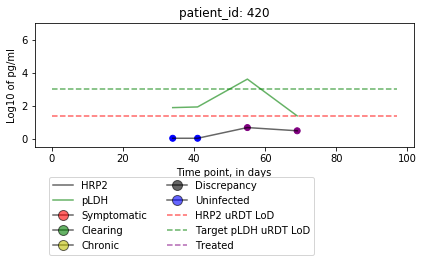

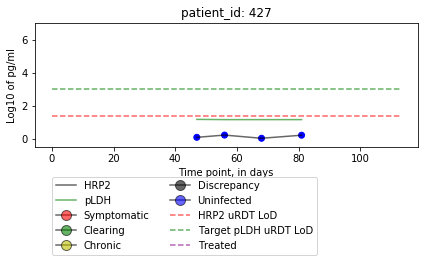

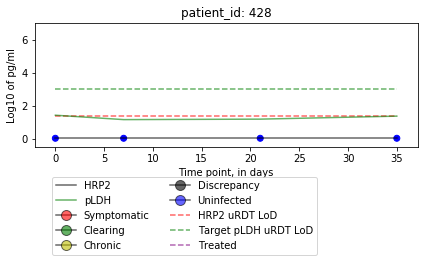

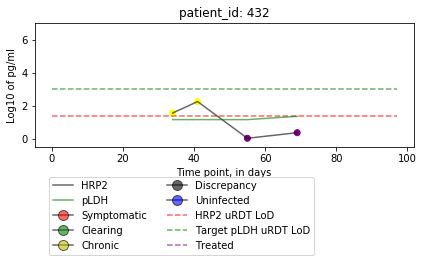

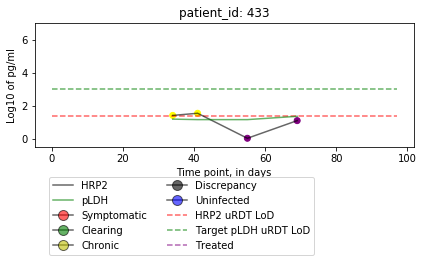

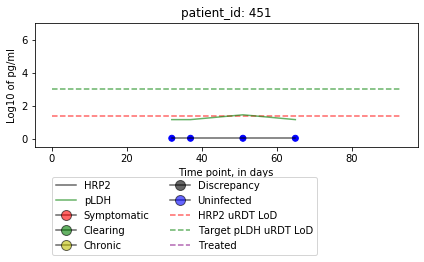

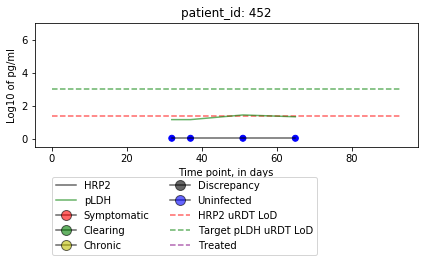

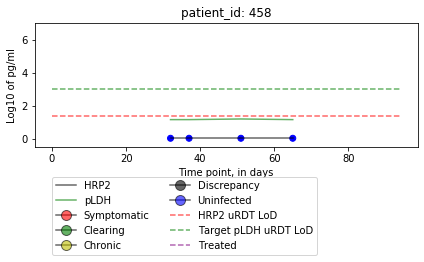

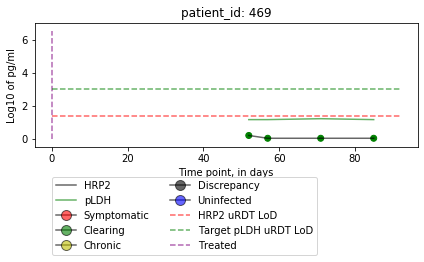

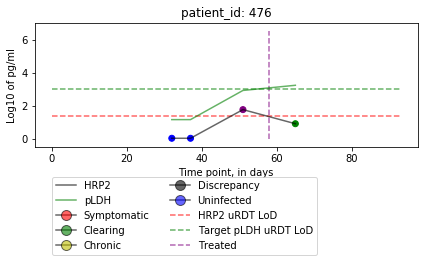

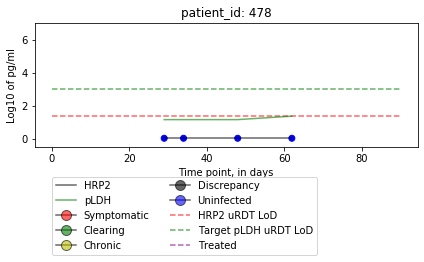

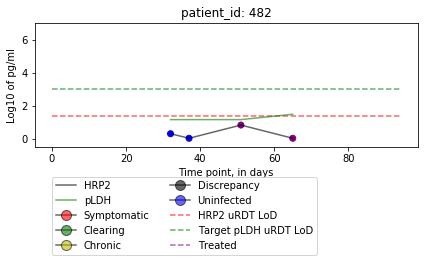

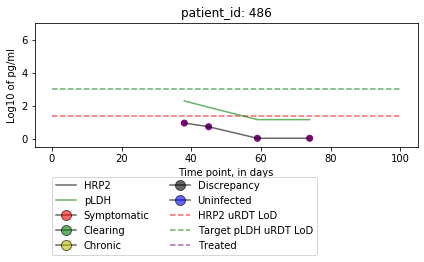

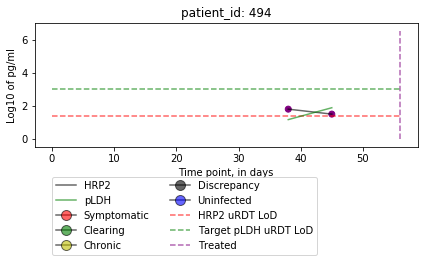

In [80]:
intro_pdf = PdfPages('C:/Users/lzoeckler/Desktop/mali_meta/NIH_mali_class_attempt.pdf')
for pid in classed_data['participant_id'].unique():
    combo = classed_data.loc[classed_data['participant_id'] == pid]
    if len(combo) > 0:
        combo.sort_values('date_dif', inplace=True)
        for_line = combo.loc[~combo['HRP2_pg_ml'].isnull()]
        max_day = max(combo['date_dif'])
        min_day = min(combo['date_dif'])
        try:
            max_y = max([max(for_line['HRP2_pg_ml']), max(for_line['LDH_Pan_pg_ml'])])
            min_y = min([min(for_line['HRP2_pg_ml']), min(for_line['LDH_Pan_pg_ml'])])
        except ValueError:
            print(pid)
            continue
        f, ax1 = plt.subplots()
        age = combo['age_yrs'].unique()[0]
        treatment_days = combo.loc[~combo['drug'].isnull(), 'date_dif'].tolist()
        for day in treatment_days:
            ax1.plot(np.array([day, day]), np.array([0, 6.5]), color='purple',
                     linestyle='--', alpha=0.6)
        hrp2_urdt_lod = ax1.plot(np.array([min_day, max_day]), np.array([1.4, 1.4]),
                                 color='red', linestyle='--', alpha=0.6)
        hrp2_urdt_lod = ax1.plot(np.array([min_day, max_day]), np.array([3, 3]),
                                 color='green', linestyle='--', alpha=0.6)
        title = """patient_id: {}""".format(pid)
        ln4 = ax1.plot(for_line['date_dif'], for_line['HRP2_pg_ml'],
                       c='black', alpha=0.6, label='HRP2')
        ln3 = ax1.plot(for_line['date_dif'], for_line['LDH_Pan_pg_ml'],
                       c='green', alpha=0.6, label='pLDH')
        ax1.scatter(for_line['date_dif'], for_line['HRP2_pg_ml'], c=for_line['class'])
        ax1.set_title(title)
        ax1.set_xlabel('Time point, in days')
        ax1.set_ylabel('Log10 of pg/ml')
        ax1.set_ylim([-.5, 7])

        # LINE STUFF
        lns = ln4 + ln3
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Symptomatic', markerfacecolor='r',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Clearing', markerfacecolor='g',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Chronic', markerfacecolor='y',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Discrepancy', markerfacecolor='k',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Uninfected', markerfacecolor='b',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], color='red', linestyle='--', label='HRP2 uRDT LoD', alpha=0.6)]
        lns = lns + [Line2D([0], [0], color='green', linestyle='--', label='Target pLDH uRDT LoD', alpha=0.6)]
        lns = lns + [Line2D([0], [0], color='purple', linestyle='--', label='Treated', alpha=0.6)]
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, bbox_to_anchor=(.75, -.2), ncol=2)

        # Actually plot stuff
        plt.tight_layout()
        intro_pdf.savefig(f)
        plt.show()
        plt.close()
    else:
        print(pid)
intro_pdf.close()